# Script for Analyzing Google Chromes HSTS List

In [1]:
import urllib
import json
import re
import csv
import base64
import matplotlib.pyplot as plt

## Custom Functions

In [2]:
def url_reader(url):
    #open url
    f = urllib.urlopen(url)
    handle = f.read()
    f.close()
    
    #URLs used are format=text, so base64 decoding has to be done
    handle = base64.b64decode(handle)
    lines = handle.splitlines(True)
    
    #any comments will break the json reading library, these are the three types of spacings that occur
    fixed_json = ''.join(line for line in lines if not (line.startswith('//') or line.startswith('    //') or line.startswith('  //')))
    read_json = json.loads(fixed_json)
    return read_json

def parse(json_f):
    total = 0
    unique_entries = set()
    
    #specific to JSON format
    for entry in (json_f['entries']):
        total += 1
        #find the last period from the right
        last_period = entry['name'].rfind(".") 
        if last_period == -1: #just for google
            ;#print entry['name']
        else:
            #extract text between 2nd to last period and last period (and account for case where that doesn't happen)
            second2last_period = entry['name'][:last_period].rfind(".")
            if second2last_period == -1:
                #print entry['name'][:last_period]
                unique_entries.add(entry['name'][:last_period])
            else:
                #print entry['name'][second2last_period+1:last_period]
                unique_entries.add(entry['name'][second2last_period+1:last_period])
    return unique_entries, total

## Leveraging Existing Files/Datasets

In [ ]:
#process data from Alexa top million
with open('top-1m.csv', 'r') as topsites:
    original_data = csv.reader(topsites)
    fast_search = dict()
    for item in original_data:
        last_period = item[1].rfind(".")
        fast_search[(item[1][0:last_period])] = item[0]

#this contains a list of Google's chromium versions
with open('hsts_versions.txt', 'r') as versions:
    v_list = versions.readlines()    
v_dict = dict()
for line in v_list:
    first_period = line.find(".")
    #this takes the first instance of a particular high-level version and saves it as the value for that key
    if (line[0:first_period] not in v_dict.keys()):
        v_dict[int(line[0:first_period])] = line.strip() #strip needed to remove \n at end
        
#compare a set of unique names to names in the Alexa Top Million list from 2017
def compare_list(url_set):
    count = 0
    average = 0.
    
    for entry in url_set:
        if fast_search.has_key(entry):
            average += float(fast_search[entry])
            count += 1
        else:
            ;#print entry

    #print "Raw count is ", len(url_set) 
    #print "in alexa top mil ", count
    #print "average: ",(average/count)
    return count, (average/count), len(url_set)

## Plotting

In [ ]:
#used for plotting
x_axis = []
y_axis = []
y_axis_topMil = []
y_axis_uniq = []
y_axis_avgRank = []

#only version 27 onwards has this HSTS list
for key in sorted(list(v_dict.keys()))[25:]:
    try:
        #specific format for this url
        #Alternate url for current version: "https://cs.chromium.org/codesearch/f/chromium/src/net/http/transport_security_state_static.json"
        temp_url = "https://chromium.googlesource.com/chromium/src/+/" + v_dict[key] + "/net/http/transport_security_state_static.json?format=text"  
        #run custom functions above
        processed_json =  url_reader(temp_url)
        json_set, total = parse(processed_json)
        raw_cnt, avg, unique_cnt = compare_list(json_set)
        
        #save for plotting
        x_axis.append(key)
        y_axis.append(total)
        y_axis_topMil.append(raw_cnt)
        y_axis_uniq.append(unique_cnt)
        y_axis_avgRank.append(avg)
    except:
        print "issue with " + v_dict[key]


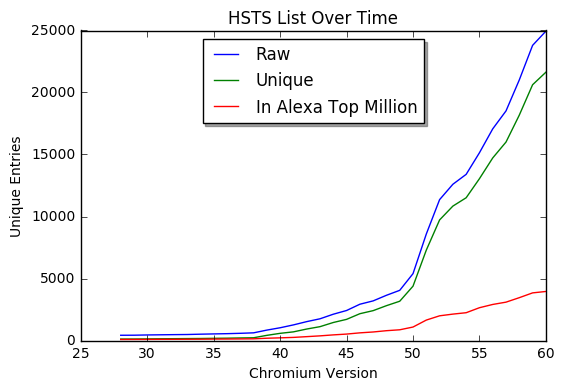

In [ ]:
plt.plot(x_axis, y_axis, label ="Raw")
plt.plot(x_axis, y_axis_uniq, label ="Unique")
plt.plot(x_axis, y_axis_topMil, label = "In Alexa Top Million")
legend = plt.legend(loc='upper center', shadow=True)
plt.xlabel("Chromium Version")
plt.ylabel("Unique Entries")
plt.title ("HSTS List Over Time")
plt.show()

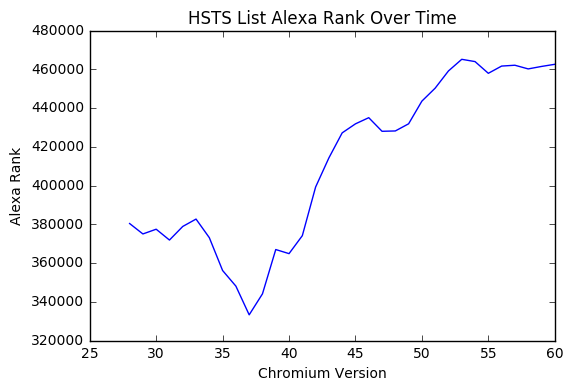

In [ ]:
plt.plot(x_axis, y_axis_avgRank, label ="Average Rank (of those in top Million)")
plt.xlabel("Chromium Version")
plt.ylabel("Alexa Rank")
plt.title ("HSTS List Alexa Rank Over Time")
plt.show()